In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

In [109]:
df = pd.read_csv('./data/train_case2.csv', sep=';')
df.shape

(70000, 13)

In [110]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [111]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), df['cardio'], random_state=42)

In [112]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Tranfsormer to select single column
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [c for c in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [c for c in X.columns]
        for col in self.columns:
            if col not in test_columns:
                X[col] = 0
        return X[self.columns]

cont_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

cont_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in cont_cols:
    transformer = Pipeline([('selector', NumberSelector(key=cont_col)),
                             ('scaler', StandardScaler())])
    cont_transformers.append((cont_col, transformer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
        ('selector', ColumnSelector(key=cat_col)),
        ('ohe', OHEncoder(key=cat_col))
    ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))
    ])
    base_transformers.append((base_col, base_transformer))

In [113]:
feats = FeatureUnion(cont_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.44594423,  0.05752649, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20194394, -0.84752919, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.01805752,  1.79801819, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.56794437, -0.01209318, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32394408, -0.29057185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.54394554, -0.70828985, ...,  0.        ,
         0.        ,  1.        ]])

In [114]:
model_logreg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

# запустим кросс-валидацию
cv_scores = cross_val_score(model_logreg, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
model_logreg.fit(X_train, y_train)
preds = model_logreg.predict_proba(X_test)[:, 1]

CV score is 0.7820906539372245+-0.004477587068241502


In [115]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'ROC-AUC {roc_auc}')

Best Threshold=0.3971092154360902, F-Score=0.735, Precision=0.656, Recall=0.837
ROC-AUC 0.7852393986644697


In [116]:
rub_test = 1400
rub_early_treatment = 15000
rub_late_treatment = 20000

In [117]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rub_ML = (FP + TP) * rub_test + FN * rub_late_treatment + TP * rub_early_treatment
print('расходы, если использовать МЛ:', rub_ML)

расходы, если использовать МЛ: 155104800


In [118]:
metrics_all = pd.DataFrame({
    'model': type(model_logreg['classifier']).__name__,
    'threshold': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC-AUC': roc_auc,
    'rub_ML': rub_ML
}, index=[0])

In [119]:
model_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

model_rf.fit(X_train, y_train)

preds = model_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print(f'ROC-AUC: {roc_auc}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

ROC-AUC: 0.7722441274308681
Best Threshold=0.37, F-Score=0.722, Precision=0.653, Recall=0.809


In [120]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rub_ML = (FP + TP) * rub_test + FN * rub_late_treatment + TP * rub_early_treatment
print('расходы, если использовать МЛ:', rub_ML)

расходы, если использовать МЛ: 155980800


In [121]:
metrics_rf = pd.DataFrame({
    'model': type(model_rf['classifier']).__name__,
    'threshold': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC-AUC': roc_auc,
    'rub_ML': rub_ML
}, index=[0])
metrics_all = pd.concat([metrics_all, metrics_rf], ignore_index=True)
metrics_all

,model,threshold,F-Score,Precision,Recall,ROC-AUC,rub_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800
1,RandomForestClassifier,0.370000,0.722352,0.652684,0.808670,0.772244,155980800


In [122]:
model_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

model_gb.fit(X_train, y_train)
preds = model_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, preds)
print(f'ROC-AUC: {roc_auc}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

ROC-AUC: 0.8032636636149935
Best Threshold=0.4109475258556618, F-Score=0.746, Precision=0.716, Recall=0.780


In [123]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rub_ML = (FP + TP) * rub_test + FN * rub_late_treatment + TP * rub_early_treatment
print('расходы, если использовать МЛ:', rub_ML)

расходы, если использовать МЛ: 155330000


In [124]:
metrics_gb = pd.DataFrame({
    'model': type(model_gb['classifier']).__name__,
    'threshold': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC-AUC': roc_auc,
    'rub_ML': rub_ML
}, index=[0])
metrics_all = pd.concat([metrics_all, metrics_gb], ignore_index=True)

In [132]:
metrics_all

,model,threshold,F-Score,Precision,Recall,ROC-AUC,rub_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800
1,RandomForestClassifier,0.370000,0.722352,0.652684,0.808670,0.772244,155980800
2,GradientBoostingClassifier,0.410948,0.746389,0.715684,0.779846,0.803264,155330000


In [131]:
metrics_all[metrics_all['rub_ML'] == metrics_all['rub_ML'].min()]

,model,threshold,F-Score,Precision,Recall,ROC-AUC,rub_ML
0,LogisticRegression,0.397109,0.735426,0.655534,0.837494,0.785239,155104800


In [133]:
def business_threshold_calibrate(y_test, y_score,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        r_test_all_r_ML = rubl_test_all - rubl_ML

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)


    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 176240000
расходы, если делать тест всем и лечить группу больных: 156680000
расходы, если использовать МЛ: 154709400
Расходы "решение не делать тесты - расходы с МL:" 21530600
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 1970600


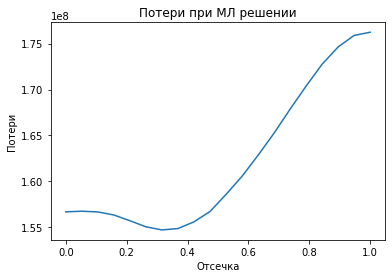

уровень порога по бизнес метрике 0.3157894736842105


In [139]:
busines_tr = business_threshold_calibrate(y_test,
                                          model_logreg.predict_proba(X_test)[:, 1],
                                          rubl_test=1400,
                                          rubl_early_treatment=15000,
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)